# Aplicando técnicas de tratamiento de textos

En este notebook aplicaremos algunas de las téncicas que hemos visto en clase. Además, incluiremos alguna que otra herramienta nueva que nos vendrá muy bien para extraer el máximo de nuestros textos

### Importamos las librerías necesarias y descarga las stopwords de nltk

In [1]:
import pandas as pd
import numpy as np
import re
import nltk

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\TheBridge\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Corpus de muestra

El corpus es el vocabulario que utilizaremos en nuestro análisis de textos. Este vocabulario puede ser obtenido de alguna de las múltiples fuentes que nos encontraremos por Internet (que podrán variar según la temática estudiada, y aparecerán en diferentes idiomas), y algunas librerías de análisis de texto ya traen incorporadas. Otra opción sería crearnos uno propio. Finalmente, la opción más rápida para muestras reducidas consiste en extraerlo de la propia fuente de datos que se va a analizar, como haremos a continuación:

In [2]:
# El corpus estará formado por un texto y una clasificación, que ayudarán a nuestro algoritmo a identificar patrones. 
# Pero para que pueda trabajar, tendremos que tratar el corpus antes:

corpus = ['The sky is blue and beautiful.',
          'Love this blue and beautiful sky!',
          'The quick brown fox jumps over the lazy dog.',
          'The brown fox is quick and the blue dog is lazy!',
          'The sky is very blue and the sky is very beautiful today',
          'The dog is lazy but the brown fox is quick!'    
]
labels = ['weather', 'weather', 'animals', 'animals', 'weather', 'animals']
corpus = np.array(corpus)
corpus_df = pd.DataFrame({'Document': corpus, 
                          'Category': labels})
corpus_df = corpus_df[['Document', 'Category']]
corpus_df

,Document,Category
0,The sky is blue and beautiful.,weather
1,Love this blue and beautiful sky!,weather
2,The quick brown fox jumps over the lazy dog.,animals
3,The brown fox is quick and the blue dog is lazy!,animals
4,The sky is very blue and the sky is very beaut...,weather
5,The dog is lazy but the brown fox is quick!,animals


## Preprocesamiento básico de texto

Tras conseguir el corpus, tendremos que procesar los textos. Si nos fijamos en el lenguaje, hay muchas formas de expresar lo mismo, y hay muchas palabras que, pese a que sean importantes gramaticalmente, no aportan información relevante, como son las stopwords. Por ejemplo: ``the`` o ``is``.

Estas palabras podemos identificarlas en diferentes frases, por lo que no aportan información que nos hagan identificar una como algo especial, es decir, no aportan significado.

Pongamos un ejemplo con la primera frase: "the sky is blue and beautiful":

Si observamos esta frase, que está marcada como "weather", identificamos algunas palabras que tienen significado por sí mismas, como son "sky", "blue", incluso "beautiful". Sin embargo, palabras como "the" o "is" aparecen en la mayoría de frases y no tienen un significado por sí mismas que nos ayuden a identificarlas con algo. Precisamente por esta condición, estas palabras están en la lista de stopwords. Por lo tanto, estas palabras las deberemos quitar para no confundir al modelo, ya que no aportan nada y solo harán que sea más fácil que interprete mal los datos y emplee más tiempo de computación.

Por ello, nos vamos a crear una función que normalice los textos que le pasemos, entendiendo _normalizar_ por quedarse con aquellas palabras que aporten valor. Veamos poco a poco esta función:

In [3]:
# Comenzamos importando un elemento de nltk para tokenizar:
wpt = nltk.WordPunctTokenizer()
# Y las stopwords, que quitaremos de nuestros textos:
stop_words = nltk.corpus.stopwords.words('english')

def normalize_document(doc, test=True):
    # lower case and remove special characters\whitespaces
    # Eliminamos todo aquello que no sea un caracter alfanumérico o un espacio:
    # ^ = distinto de
    # \s = espacio
    # a-z = de la a a la z (minúsculas). A-Z = mayúsculas. 0-9 = del 0 al 9
    # '' = sustituir por '' (= eliminar)
    # re.I = ignora si son mayúsculas o minúsculas
    doc = re.sub(r'[^a-zA-Z0-9\s]', '', doc, re.I)
    
    # Convertimos a minúsculas:
    doc = doc.lower()
    # Quitamos espacios que sobran:
    doc = doc.strip()
    # Tokenizamos el texto:
    tokens = wpt.tokenize(doc)
    # Si queremos que se impriman, ponemos ese parámetro a True:
    if test:
        print(tokens)
    # Una vez tokenizado, tendremos una lista de palabras. Eliminamos las que estén en las stopwords:
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # Si queremos que se impriman, ponemos ese parámetro a True:
    if test:
        print(filtered_tokens)
    # Finalmente, recreamos un único string con todas las palabras separadas por espacios
    doc = ' '.join(filtered_tokens)
    return doc

Ahora ya tenemos nuestra función que normaliza frases:

In [4]:
normalize_document("The sky is blue and beautiful")

['the', 'sky', 'is', 'blue', 'and', 'beautiful']
['sky', 'blue', 'beautiful']


'sky blue beautiful'

Sin embargo, lo que queremos es utilizarlo con unas cuántas entradas, es decir, como si estuviéramos trabajando con un array de textos. Para ello, podemos utilizar la función ``np.vectorize()``. Veamos cómo funciona con un ejemplo:

Vamos a crearnos una función que recibe un parámetro y devuelve otro parámetro, en concreto, vamos a utilizar una función que nos diga si un número es par o no:

In [5]:
def es_par(m):
    if m%2 == 0:
        return True
    else:
        return False

In [6]:
es_par(2)

True

In [7]:
es_par(3)

False

Como vemos, funciona con números sueltos pero, ¿qué pasa si usamos una lista o un array?

In [8]:
es_par(np.array([1, 2, 3]))

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

La función recibe un conjunto de datos en lugar de un número solo, por lo que no sabe qué hacer y falla. En cambio, si usamos la función que hemos comentado antes, ``np.vectorize()`` esto se soluciona:

In [9]:
es_par_vector = np.vectorize(es_par)
# Ahora ya es posible usarla con arrays
m = np.array([1, 2, 3, 4, 5])
es_par_vector(m)

array([False,  True, False,  True, False])

Como puedes comprobar, la función vectorizada nos permite utilizar conjuntos de datos, así que si lo usamos sobre nuestra función de normalización de frases, podremos utilizarla con un array de textos, como es la variable ``corpus``:

In [10]:
corpus

array(['The sky is blue and beautiful.',
       'Love this blue and beautiful sky!',
       'The quick brown fox jumps over the lazy dog.',
       'The brown fox is quick and the blue dog is lazy!',
       'The sky is very blue and the sky is very beautiful today',
       'The dog is lazy but the brown fox is quick!'], dtype='<U56')

In [11]:
frase = 'The sky is blue and beautiful.'
normalize_document(frase)

['the', 'sky', 'is', 'blue', 'and', 'beautiful']
['sky', 'blue', 'beautiful']


'sky blue beautiful'

In [12]:
normalize_corpus = np.vectorize(normalize_document)

In [13]:
norm_corpus = normalize_corpus(corpus)

['the', 'sky', 'is', 'blue', 'and', 'beautiful']
['sky', 'blue', 'beautiful']
['the', 'sky', 'is', 'blue', 'and', 'beautiful']
['sky', 'blue', 'beautiful']
['love', 'this', 'blue', 'and', 'beautiful', 'sky']
['love', 'blue', 'beautiful', 'sky']
['the', 'quick', 'brown', 'fox', 'jumps', 'over', 'the', 'lazy', 'dog']
['quick', 'brown', 'fox', 'jumps', 'lazy', 'dog']
['the', 'brown', 'fox', 'is', 'quick', 'and', 'the', 'blue', 'dog', 'is', 'lazy']
['brown', 'fox', 'quick', 'blue', 'dog', 'lazy']
['the', 'sky', 'is', 'very', 'blue', 'and', 'the', 'sky', 'is', 'very', 'beautiful', 'today']
['sky', 'blue', 'sky', 'beautiful', 'today']
['the', 'dog', 'is', 'lazy', 'but', 'the', 'brown', 'fox', 'is', 'quick']
['dog', 'lazy', 'brown', 'fox', 'quick']


In [14]:
norm_corpus

array(['sky blue beautiful', 'love blue beautiful sky',
       'quick brown fox jumps lazy dog', 'brown fox quick blue dog lazy',
       'sky blue sky beautiful today', 'dog lazy brown fox quick'],
      dtype='<U30')

### EJERCICIO

Prueba a utilizar la función de normalización que hemos usado anteriormente con una lista de frases en inglés a ver qué obtienes:

### EJERCICIO

Hemos visto que también existen paquetes de stopwords en español. ¿Podrías replicar la función que acabamos de ver para tokenizar nuestras frases pero adaptándola al castellano?

Pruébala con unas frases:

## Bag of Words

Una vez tenemos nuestro corpus normalizado, podemos pasar a utilizar diferentes técnicas. En este caso, comenzaremos por la ya comentaada en clase Bag of Words, para la cual utilizábamos el objeto CountVectorizer:

In [15]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer()
cv_matrix = cv.fit_transform(norm_corpus)
cv_matrix = cv_matrix.toarray()
cv_matrix

array([[1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0],
       [0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0],
       [0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0],
       [1, 1, 0, 0, 0, 0, 0, 0, 0, 2, 1],
       [0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0]], dtype=int64)

Nos ha devuelto un array, pero podemos recuperar las palabras a partir del método ``get_feature_names()``. Podríamos, incluso, hacer las comprobaciones de que ha hecho lo que le hemos pedido:

In [16]:
vocab = cv.get_feature_names()
pd.DataFrame(cv_matrix, columns=vocab)

,beautiful,blue,brown,dog,fox,jumps,lazy,love,quick,sky,today
0,1,1,0,0,0,0,0,0,0,1,0
1,1,1,0,0,0,0,0,1,0,1,0
2,0,0,1,1,1,1,1,0,1,0,0
3,0,1,1,1,1,0,1,0,1,0,0
4,1,1,0,0,0,0,0,0,0,2,1
5,0,0,1,1,1,0,1,0,1,0,0


# Bag of N-Grams

Como hemos visto, Bag of words es una particularización de Bag of n-grams para n=1. Sin embargo, si en lugar de palabras sueltas queremos añadir contexto a nuestro análisis, podemos elegir n-grams de nivel superior. Por ejemplo, de 2 elementos (bigramas):

In [17]:
bv = CountVectorizer(ngram_range=(2,2))
bv_matrix = bv.fit_transform(norm_corpus)
bv_matrix = bv_matrix.toarray()
vocab = bv.get_feature_names()
bigramas= pd.DataFrame(bv_matrix, columns=vocab)
bigramas.shape

(6, 17)

In [18]:
bigramas

,beautiful sky,beautiful today,blue beautiful,blue dog,blue sky,brown fox,dog lazy,fox jumps,fox quick,jumps lazy,lazy brown,lazy dog,love blue,quick blue,quick brown,sky beautiful,sky blue
0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,0,0,0,0,0,1,0,1,0,1,0,1,0,0,1,0,0
3,0,0,0,1,0,1,1,0,1,0,0,0,0,1,0,0,0
4,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1
5,0,0,0,0,0,1,1,0,1,0,1,0,0,0,0,0,0


# TF-IDF

Por último, antes de pasar a la siguiente fase, vamos a ver una tercera opción. Se trata de la transformación TF-IDF, cuyas siglas vienen del inglés _Term-Frequency times Inverse Document-Frequency_ (en castellano sería algo así como “frecuencia del término por frecuencia inversa de documento”).

Básicamente, se trata de un método que se basa en una ponderación de los términos en función de su relevancia. Para ello, calcula el número de veces que aparece en un documento, y lo divide entre un factor que aumenta con el número de apariciones en otros documentos. De este modo, cuando un término aparece muchas veces en muchos documentos, no será relevante pues no será algo que permita identificar a ese documento en concreto. Sin embargo, si un término aparece muchas veces en un documento, pero pocas en el resto, será un factor particular de esos pocos documentos que lo contienen, por lo que será una posible característica común que los relacione entre sí.

La fórmula por la que se rige es la siguiente:


$$
tfidf(t, d) = tf(t,d) * idf(t)
$$

donde $t$ is un término (o palabra, si estamos con n-gramas de n=1) y $d$ es un documento (es decir, uno de los textos de nuestro dataset)

Además, $tf(t, d)$ hace referencia al número de términos en el documento actual, mientras que $idf(t)$ viene definida de la siguiente manera:

$$
idf(t) = log(\frac{1 + n_d}{1 + df(d, t)}) +1
$$

donde $n_d$ es el número de documentos y $df(d,t)$ es el número de documentos que contienen el término $t$

Si quieres conocer en profundidad esta técnica, puedes consultar la [documentación de scikit-learn](http://scikit-learn.org/stable/modules/feature_extraction.html#tfidf-term-weighting)


Veamos cómo implementarlo de manera sencilla con el objeto correspondiente, cuya documentación podrás encontrar [aquí](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html#sklearn.feature_extraction.text.TfidfVectorizer).

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer

tv = TfidfVectorizer(use_idf=True)
tv_matrix = tv.fit_transform(norm_corpus)
tv_matrix = tv_matrix.toarray()

vocab = tv.get_feature_names()
df_matrix = pd.DataFrame(np.round(tv_matrix, 2), columns=vocab)
df_matrix

,beautiful,blue,brown,dog,fox,jumps,lazy,love,quick,sky,today
0,0.60,0.52,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.60,0.00
1,0.46,0.39,0.00,0.00,0.00,0.00,0.00,0.66,0.00,0.46,0.00
2,0.00,0.00,0.38,0.38,0.38,0.54,0.38,0.00,0.38,0.00,0.00
3,0.00,0.36,0.42,0.42,0.42,0.00,0.42,0.00,0.42,0.00,0.00
4,0.36,0.31,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.72,0.52
5,0.00,0.00,0.45,0.45,0.45,0.00,0.45,0.00,0.45,0.00,0.00


### EJERCICIO

La función TF-IDF se engloba dentro del IR (Information Retrieval, Recuperación de Información), que se encarga de rankear documentos dentro de una gran selección de los mismos, como hacen los buscadores de Internet. Google, por ejemplo, utiliza este tipo de técnicas para saber qué devolverte, y en qué orden, cuando realizas una búsqueda. Evidentemente, los motores de Google utilizan algoritmos mucho más complejos, pero parten de esta base.

Imagina que creas un buscador que se basa en la TF-IDF:
1. ¿Qué documento devolverías si buscan el término _beautiful_?
2. ¿Y si buscan el término _sky_?
3. Crea una función que reciba una matriz de estas características (con un número de columnas que no sepamos de antemano) y devuelva el docuento (o los documentos, si hay empate) que devolvería nuestro buscador en primer lugar.

La función recibirá un dataframe con esa matriz y un término, que deberá buscar en ella

4. ¿Podrías replicar en una función todo el proceso, desde la lista de textos hasta que devuelva el texto (o los textos) que mejor se identifique(n) con el término buscado?

## Similitud de documentos

Una vez hemos elegido una de las 3 técnicas anteriores, podemos pasar a calcular la matriz de similitud, que nos permite ver cuánto de parecidas son dos textos entre sí. Lo necesitaremos para continuar con nuestro estudio:

In [20]:
from sklearn.metrics.pairwise import cosine_similarity

similarity_matrix = cosine_similarity(tv_matrix)
similarity_df = pd.DataFrame(similarity_matrix)
similarity_df

,0,1,2,3,4,5
0,1.000000,0.753128,0.000000,0.185447,0.807539,0.000000
1,0.753128,1.000000,0.000000,0.139665,0.608181,0.000000
2,0.000000,0.000000,1.000000,0.784362,0.000000,0.839987
3,0.185447,0.139665,0.784362,1.000000,0.109653,0.933779
4,0.807539,0.608181,0.000000,0.109653,1.000000,0.000000
5,0.000000,0.000000,0.839987,0.933779,0.000000,1.000000


En esta gráfica podemos interpretar que el texto 3 es el más próximo al texto 5, lo que significa que son muy parecidos. Mientras que es el más alejado al texto 4, lo que significa que no se parecen. Lo podemos comprobar:

In [21]:
print(normalize_document(corpus[3], test=False))
print(normalize_document(corpus[5], test=False))

brown fox quick blue dog lazy
dog lazy brown fox quick


In [22]:
print(normalize_document(corpus[3], test=False))
print(normalize_document(corpus[4], test=False))

brown fox quick blue dog lazy
sky blue sky beautiful today


### EJERCICIO

Prueba a realizar la similitud de documentos usando el modelo Bag of n-grams, con diferentes valores de n:

### Clustering de documentos usando la matriz de similitud

Con la matriz de similitud podemos identificar clusters de textos. En este caso, utilizaremos el algoritmo KMeans, que es un algoritmo de clustering que nos permite estudiar los patrones que relacionan los registros entre sí para crear grupos de características similares. Como veremos cuando lleguemos a ello, este algoritmo necesita que le digamos cuántos grupos queremos que busque, que en este caso le diremos 2:

In [23]:
from sklearn.cluster import KMeans

km = KMeans(n_clusters=2)
km.fit_transform(similarity_df)
cluster_labels = km.labels_
cluster_labels = pd.DataFrame(cluster_labels, columns=['ClusterLabel'])
pd.concat([corpus_df, cluster_labels], axis=1)

,Document,Category,ClusterLabel
0,The sky is blue and beautiful.,weather,1
1,Love this blue and beautiful sky!,weather,1
2,The quick brown fox jumps over the lazy dog.,animals,0
3,The brown fox is quick and the blue dog is lazy!,animals,0
4,The sky is very blue and the sky is very beaut...,weather,1
5,The dog is lazy but the brown fox is quick!,animals,0


Como podemos comprobar, parece que la categoría se ha identificado bien.

### EJERCICIO

Como hemos visto, hemos podido realizar un modelo desde el comienzo hasta el final. Repasa lo que hemos visto hasta aquí e intenta, utilizando los métodos ``transform`` de los objetos que ya han sido entrenados con las muestras, realizar la predicción de una frase nueva. Créate una función que te devuelva la predicción de una frase. ¿Podrías realizarlo para que recibiera una lista de textos? (En aquellos puntos que existan más de una alternativa, elije la que te apetezca, o añade un parámetro para que se pueda decidir)

### Modelo de tópicos

Otra opción que se nos presenta como alternativa a la matriz de similitud es el modelo de tópicos.

Los tópicos hacen referencia a la temática del texto. Con el modelo de tópicos, lo que buscamos es extraer temáticas comunes entre los textos. En este caso, vamos a utilizar un método similar al visto con PCA, LDA. Ambos se tratan de métodos de reducción de dimensionalidad. Ene ste caso, usaremos LDA porque los elementos que nos devuelve suman 1, por lo que son complementarioas y nos permitirá realizar una comparación porcentual entre los tópicos.

En este caso, y como hemos estado haciendo anteriormente, le tendremos que indicar cuántos tópicos queremos buscar. En este caso, para que tenga cierta coherencia con lo que hemos visto anteriormente, indicaremos 2 grupos (aunque con más también funcionaría)

In [24]:
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_components=2, max_iter=100, random_state=42)
dt_matrix = lda.fit_transform(tv_matrix)
features = pd.DataFrame(dt_matrix, columns=['T1', 'T2'])
features

# Los dos tópicos suman 1
# El tópico mayoritario te da la clase única
# Lo interesante es ver la proporción de cada tópico

,T1,T2
0,0.190548,0.809452
1,0.176804,0.823196
2,0.846184,0.153816
3,0.814863,0.185137
4,0.180516,0.819484
5,0.839172,0.160828


### Mostrando los tópicos y sus pesos

Dado que hemos utilizado el modelo LDA, y tenemos el vocabulario que hemos utilziado, podemos asociarlo a cada tópico y qué peso se le ha adjudicado. A mayor peso, mayor importancia tendrá dentro de ese grupo.

In [25]:
tt_matrix = lda.components_
for topic_weights in tt_matrix:
    topic = [(token, weight) for token, weight in zip(vocab, topic_weights)]
    topic = sorted(topic, key=lambda x: -x[1]) # ordeno por el peso decreciente
    topic = [item for item in topic if item[1] > 0.6] # me quedo solo con los pesos mayores de 0.6
    print(topic)
    print()

[('brown', 1.7273638692668465), ('dog', 1.7273638692668465), ('fox', 1.7273638692668465), ('lazy', 1.7273638692668465), ('quick', 1.7273638692668465), ('jumps', 1.0328325272484777), ('blue', 0.7731573162915626)]

[('sky', 2.264386643135622), ('beautiful', 1.9068269319456903), ('blue', 1.7996282104933266), ('love', 1.148127242397004), ('today', 1.0068251160429935)]



## Clustering de documentos usando los tópicos

Al igual que hemos visto para la matriz de similitud, también podemos realizar el clustering de documentos a base del modelo de tópicos que acabamos de ver:

In [26]:
km = KMeans(n_clusters=2)
km.fit_transform(features)
cluster_labels = km.labels_
cluster_labels = pd.DataFrame(cluster_labels, columns=['ClusterLabel'])
pd.concat([corpus_df, cluster_labels], axis=1)

# ahora agrupo en clusters usando los tópicos, no la similaridad basada en cosenos


,Document,Category,ClusterLabel
0,The sky is blue and beautiful.,weather,1
1,Love this blue and beautiful sky!,weather,1
2,The quick brown fox jumps over the lazy dog.,animals,0
3,The brown fox is quick and the blue dog is lazy!,animals,0
4,The sky is very blue and the sky is very beaut...,weather,1
5,The dog is lazy but the brown fox is quick!,animals,0


### EJERCICIO

Como hemos visto, hemos podido realizar un modelo desde el comienzo hasta el final. Repasa lo que hemos visto hasta aquí e intenta, utilizando los métodos ``transform`` de los objetos que ya han sido entrenados con las muestras, realizar la predicción de una frase nueva. Créate una función que te devuelva la predicción de una frase. ¿Podrías realizarlo para que recibiera una lista de textos? (Sí, es el mismo ejercicio que en el apartado anterior, solo que en este deberás hacerlo basándote en los tópicos)

In [27]:
# # Instalamos gensim. PAra ello, abre el Anaconda Prompt e introduce el siguiente comando:
# pip install gensim

# Word Embeddings

Principalmente, la técnica de word embedding se basa en el mapeo de las palabras en vectores. Para representar un ejemplo de cómo funcionan, utilizaremos el modelo word2vec, que por debajo utilizará una red neuronal para entender relaciones entre palabras (así como sinónimos) y convertir los textos en vectores:

In [28]:
from gensim.models import word2vec

# Tokenizamos el corpus (parecido a lo que hemos hecho anteriormente):
wpt = nltk.WordPunctTokenizer()
tokenized_corpus = [wpt.tokenize(document) for document in norm_corpus]

# Establecemos algunos parámetros (que dependerá de lo que queramos):
feature_size = 10    # dimensión del vector de palabra  
window_context = 10          # tamaño de la ventana de contexto                                                                                    
min_word_count = 1   # mínimo conteo de palabras                        
sample = 1e-3   # Downsample para palabras frecuentes

w2v_model = word2vec.Word2Vec(tokenized_corpus, size=feature_size, 
                          window=window_context, min_count = min_word_count,
                          sample=sample)

**size**: el número de dimensiones de los embeddings, cuyo valor predeterminado es 100. Es decir, el número de dimensiones de los vectores untermedios. Un valor típico que suele tomar este parámetro es 300, pues se corresponde con el que Google utilizó para entrenar su modelo basado en el dataset de Google News, el cual puedes encontrar [aquí](https://code.google.com/archive/p/word2vec/).

**window**: la distancia máxima entre una palabra de destino y palabras alrededor de la palabra de destino, que se utilizarán para darle contexto a la palabra analizada. Por ejemplo, para una ventana de tamaño 2, los pares de palabras que se tomarían para cada palabra serían:
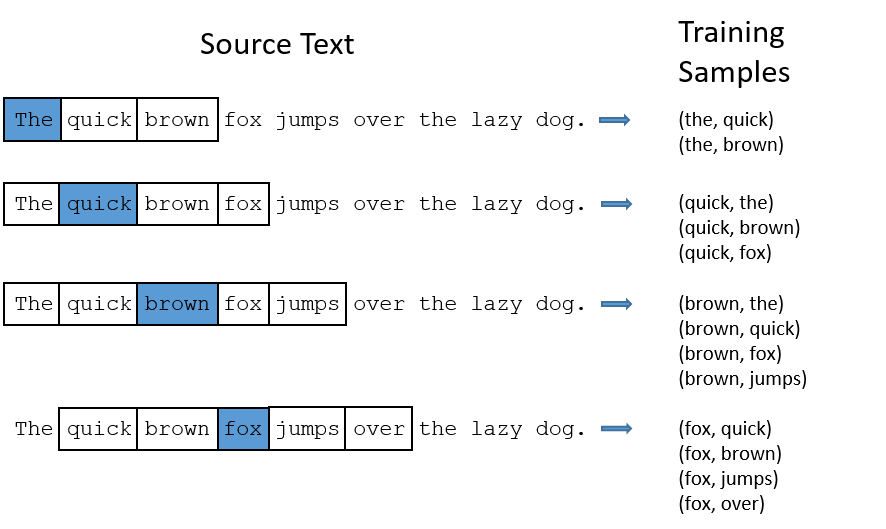

**min_count**: el número mínimo de apariciones para considerar una palabra al entrenar el modelo; las palabras con menos ocurrencias que este recuento serán ignoradas. ¿OJO! Las palabras ignoradas se eliminan ANTES de entrenar, por lo que la ventana tomará las siguientes palabras. Por ejemplo: en la frase anterior, si la palabra ignorada es "brown", los pares de palabras al analizar la palabra "fox" para una ventana de 2, serían:
  - (fox, **the**)
  - (fox, quick)
  - (fox, jumps)
  - (fox, over)
  
El valor predeterminado para min_count es 5.

Una vez creado el modelo, podemos utilizarlo para convertir las palabras que conoce:

In [29]:
w2v_model.wv['sky']
# de palabra a vector

array([ 0.02296141,  0.006746  , -0.02645167, -0.01589399, -0.00828661,
        0.03964581,  0.03077236,  0.03948477,  0.02372696, -0.0455016 ],
      dtype=float32)

En cambio, si no las conoce:

In [30]:
w2v_model.wv['ball']
# de palabra a vector

KeyError: "word 'ball' not in vocabulary"

Para aplicar algún método de clustering sobre el word2vec, debemos calcular la media de cada uno de los vectores, que nos permitirá conocer el centro de cada palabra:

In [31]:
def average_word_vectors(words, model, vocabulary, num_features):
    
    feature_vector = np.zeros((num_features,),dtype="float64")
    nwords = 0.
    
    for word in words:
        if word in vocabulary: 
            nwords = nwords + 1.
            feature_vector = np.add(feature_vector, model[word])
    
    if nwords:
        feature_vector = np.divide(feature_vector, nwords)
        
    return feature_vector


def averaged_word_vectorizer(corpus, model, num_features):
    vocabulary = set(model.wv.index2word)
    features = [average_word_vectors(tokenized_sentence, model.wv, vocabulary, num_features)
                    for tokenized_sentence in corpus]
    return np.array(features)

In [32]:
w2v_feature_array = averaged_word_vectorizer(corpus=tokenized_corpus, model=w2v_model, num_features=feature_size)
pd.DataFrame(w2v_feature_array)

,0,1,2,3,4,5,6,7,8,9
0,0.001510,0.014467,-0.004992,0.003650,-0.029781,0.003971,-0.005203,0.021886,0.032318,0.000892
1,0.006843,0.010544,0.006616,-0.006343,-0.022642,-0.007129,0.003204,0.024260,0.029169,0.004054
2,0.003075,0.004368,-0.003262,0.008396,-0.021574,0.007926,-0.001007,-0.003856,-0.020341,-0.002169
3,-0.001507,0.008154,-0.007662,0.010262,-0.032273,0.003811,-0.002417,-0.002115,-0.018192,0.007642
4,0.007381,0.010737,-0.017343,0.003965,-0.015087,0.006097,0.011204,0.011141,0.027192,-0.007062
5,0.002109,0.003395,-0.002044,0.014940,-0.031284,0.006969,-0.001129,-0.005423,-0.026539,0.003688


In [33]:
from sklearn.cluster import AffinityPropagation

# en affinitypropagation no se especifica el número de clusters, lo encuentra él

ap = AffinityPropagation()
ap.fit(w2v_feature_array)
cluster_labels = ap.labels_
cluster_labels = pd.DataFrame(cluster_labels, columns=['ClusterLabel'])
pd.concat([corpus_df, cluster_labels], axis=1)

C:\Users\TheBridge\anaconda3\lib\site-packages\sklearn\cluster\_affinity_propagation.py:146: FutureWarning: 'random_state' has been introduced in 0.23. It will be set to None starting from 0.25 which means that results will differ at every function call. Set 'random_state' to None to silence this warning, or to 0 to keep the behavior of versions <0.23.
  warnings.warn(("'random_state' has been introduced in 0.23. "


,Document,Category,ClusterLabel
0,The sky is blue and beautiful.,weather,0
1,Love this blue and beautiful sky!,weather,0
2,The quick brown fox jumps over the lazy dog.,animals,1
3,The brown fox is quick and the blue dog is lazy!,animals,1
4,The sky is very blue and the sky is very beaut...,weather,0
5,The dog is lazy but the brown fox is quick!,animals,1


## Otras cosas de word2vec

In [34]:
import gensim.downloader as api
corpus = api.load('text8')

In [35]:
from gensim.models.word2vec import Word2Vec
model = Word2Vec(corpus)

In [36]:
# Parecidos:
model.most_similar('king')

<ipython-input-36-2a7713ffc1e8>:2: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  model.most_similar('king')


[('prince', 0.725441575050354),
 ('queen', 0.7162436246871948),
 ('emperor', 0.6972247362136841),
 ('throne', 0.6926025152206421),
 ('kings', 0.68238765001297),
 ('regent', 0.68035489320755),
 ('vii', 0.6767832040786743),
 ('aragon', 0.6767212748527527),
 ('elector', 0.6682478785514832),
 ('pharaoh', 0.6657418012619019)]

In [37]:
# Combinaciones:
model.most_similar(positive = ['king', 'woman'], negative=['man'])

<ipython-input-37-f25ffeedec45>:2: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  model.most_similar(positive = ['king', 'woman'], negative=['man'])


[('queen', 0.6856938600540161),
 ('empress', 0.6527258157730103),
 ('prince', 0.6290709376335144),
 ('throne', 0.5954083800315857),
 ('emperor', 0.594462513923645),
 ('princess', 0.5940581560134888),
 ('elizabeth', 0.5926085710525513),
 ('son', 0.5905234217643738),
 ('regent', 0.5747319459915161),
 ('sigismund', 0.5659385919570923)]

In [38]:
# Combinaciones:
model.most_similar(positive = ['house', 'christian'])

<ipython-input-38-1ca03a2672fa>:2: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  model.most_similar(positive = ['house', 'christian'])


[('congregation', 0.7008602619171143),
 ('church', 0.6928653717041016),
 ('evangelical', 0.6332401037216187),
 ('baptist', 0.6297503709793091),
 ('lords', 0.6277428865432739),
 ('episcopal', 0.6266598701477051),
 ('anglican', 0.6255879402160645),
 ('priesthood', 0.624977171421051),
 ('calvinist', 0.6227996349334717),
 ('reformed', 0.6062453985214233)]